<a href="https://colab.research.google.com/github/VintageGold/Text_Summarization/blob/main/Topic_modeling_gensim_LDA_for_TMH_liang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
import json
import pandas as pd
import string
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from  vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Mounted at /content/gdrive


In [2]:
df_metadata = pd.read_csv('/content/gdrive/My Drive/Text_Summarization/Telehealth_article.csv')

In [3]:
def clean_text(text,lowercase=True):
    
    corpus =  text
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans("","",string.punctuation + "\n" + "\tb")
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return ' '.join(remove_extra_whitespaces)

In [4]:
df_metadata['Content_Clean'] = df_metadata['Content'].apply(lambda text: clean_text(text))
df_metadata['Content_Length'] = df_metadata['Content_Clean'].apply(lambda text: len(text))
df_metadata['Abstract_Length'] = df_metadata['Abstract'].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split(" ")[1:])
df_metadata['Parsed_Keywords_Length'] = df_metadata['Parsed_Keywords'].apply(lambda text: len(text))

In [100]:
df = pd.read_csv('/content/gdrive/My Drive/Text_Summarization/Telehealth_article_1.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Index,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Clean,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length
0,0,0,1,Psychological Servies,The Effectiveness of Telepsychology With Veterans: A Meta-Analysis of Services Delivered by Vide...,2021,Michael J. McClellan; Richard Osbaldiston; Rongxiu Wu; Rachael Yeager; Addison D. Monroe; Tyler ...,Veterans face a variety of stressors due to their military service and are more likely to develo...,"KEYWORDS:\n\ntelepsychology, meta-analysis, veteran, videoconference, phone","McClellan, M. J., Osbaldiston, R., Wu, R., Yeager, R., Monroe, A. D., McQueen, T., & Dunlap, M. ...","Veterans face a variety of stressors related to their military service (Institute of Medicine, 2...",veterans face a variety of stressors related to their military service institute of medicine 201...,35996,2411,"['telepsychology,', 'meta-analysis,', 'veteran,', 'videoconference,', 'phone']",5
1,1,1,2,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remote Child Custody Evaluations (RCCES): The Empirica...,2021,Milfred D. Dale; Desiree Smith,"The COVID-19 pandemic and its requirements for social distancing and limited, if any, in-person ...","KEYWORDS:\n\nremote child custody evaluations, videoconferencing, telemental health, ethics in t...","Dale, M. D., & Smith, D. (2021). Making the case for videoconferencing and remote child custody ...",The impact of the COVID-19 pandemic on the child custody evaluation (CCE) community has been ast...,the impact of the covid19 pandemic on the child custody evaluation cce community has een astound...,71152,1577,"['remote', 'child', 'custody', 'evaluations,', 'videoconferencing,', 'telemental', 'health,', 'e...",10
2,2,2,3,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Priorities, and Policy Directions",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychology that is relatively underdeveloped considering ...,"KEYWORDS:\n\nforensic e-mental health, telehealth, telepsychology, forensic evaluation, corrections","Kois, L. E., Cox, J., & Peck, A. T. (2021). Forensic e-mental health: Review, research prioritie...","In November 2019, COVID-19—the infectious, highly communicable, and potentially fatal disease ca...",in novemer 2019 covid19—the infectious highly communicale and potentially fatal disease caused y...,60855,1842,"['forensic', 'e-mental', 'health,', 'telehealth,', 'telepsychology,', 'forensic', 'evaluation,',...",8
3,3,3,4,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in University Training Clinics: Considerations and Cur...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing numerous challenges resulting from the COVID-19 pand...,"KEYWORDS:\n\neducation and training, telepsychology, COVID-19, pandemic","Baier, A. L., & Danzo, S. (2021). Moving toward a new era of telepsychology in university traini...",Anxiety and depressive disorders are among the most common and impairing mental illnesses in the...,anxiety and depressive disorders are among the most common and impairing mental illnesses in the...,29089,1650,"['education', 'and', 'training,', 'telepsychology,', 'COVID-19,', 'pandemic']",6
4,4,4,5,Practice Innovations,Navigating Changes in the Physical and Psychological Spaces of Psychotherapists During Covid-19:...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the beginning of 2020 changed psychotherapists’ person...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, pandemic, mixed method","Shklarski, L., Abrams, A., & Bakst, E. (2021). Navigating changes in the physical and psychologi...","In mid-March, 2020, the authors—as well as the majority of therapists—were advised to work from ...",in midmarch 2020 the authors—as well as the majority of therapists—were advi

In [96]:
# Run in python console
import nltk; nltk.download('stopwords')

import sys
!{sys.executable} -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [98]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis==2.1.2)
!pip install pyldavis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/bin/bash: -c: line 0: syntax error near unexpected token `)'
/bin/bash: -c: line 0: `pip install pyLDAvis==2.1.2)'


### What does LDA do?
####  Prepare Stopwords

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Remove emails and newline characters

In [101]:
# Convert to list
data = df.Content_Clean.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['veterans face a variety of stressors related to their military service '
 'institute of medicine 2014 tanielian et al 2008 most veterans who return '
 'from military conflict do not have a mental health condition ut all veterans '
 '“experience a period of readjustment as they reintegrate into life with '
 'family friends and community” sustance ause and mental health services '
 'administration samhsa 2012 p 1 tanielian et al 2008 those individuals must '
 'juggle a variety of sometimes conflicting family and militaryrelated '
 'responsiilities learn to readjust to environments where ehaviors associated '
 'with a constant state of readiness are no longer needed and process '
 'comatrelated exposure that may collectively contriute to prolems for oth '
 'veterans and their families institute of medicine 2014 samhsa 2012veterans '
 'who are exposed to comat are more likely to report normal reactions to '
 'stress including depression hopelessness insomnia nightmares feelings of '
 're

In [102]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['veterans', 'face', 'variety', 'of', 'stressors', 'related', 'to', 'their', 'military', 'service', 'institute', 'of', 'medicine', 'tanielian', 'et', 'al', 'most', 'veterans', 'who', 'return', 'from', 'military', 'conflict', 'do', 'not', 'have', 'mental', 'health', 'condition', 'ut', 'all', 'veterans', 'experience', 'period', 'of', 'readjustment', 'as', 'they', 'reintegrate', 'into', 'life', 'with', 'family', 'friends', 'and', 'community', 'sustance', 'ause', 'and', 'mental', 'health', 'services', 'administration', 'samhsa', 'tanielian', 'et', 'al', 'those', 'individuals', 'must', 'juggle', 'variety', 'of', 'sometimes', 'conflicting', 'family', 'and', 'militaryrelated', 'responsiilities', 'learn', 'to', 'readjust', 'to', 'environments', 'where', 'ehaviors', 'associated', 'with', 'constant', 'state', 'of', 'readiness', 'are', 'no', 'longer', 'needed', 'and', 'process', 'comatrelated', 'exposure', 'that', 'may', 'collectively', 'contriute', 'to', 'prolems', 'for', 'oth', 'veterans', 'an

### Build the Bigram, Trigram Models 

In [103]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['veterans', 'face', 'variety', 'of', 'stressors', 'related', 'to', 'their', 'military_service', 'institute', 'of', 'medicine', 'tanielian', 'et', 'al', 'most', 'veterans', 'who', 'return', 'from', 'military', 'conflict', 'do', 'not', 'have', 'mental', 'health', 'condition', 'ut', 'all', 'veterans', 'experience', 'period', 'of', 'readjustment', 'as', 'they', 'reintegrate', 'into', 'life', 'with', 'family', 'friends', 'and', 'community', 'sustance_ause', 'and', 'mental', 'health', 'services', 'administration', 'samhsa', 'tanielian', 'et', 'al', 'those', 'individuals', 'must', 'juggle', 'variety', 'of', 'sometimes', 'conflicting', 'family', 'and', 'militaryrelated', 'responsiilities', 'learn', 'to', 'readjust', 'to', 'environments', 'where', 'ehaviors', 'associated', 'with', 'constant', 'state', 'of', 'readiness', 'are', 'no_longer', 'needed', 'and', 'process', 'comatrelated', 'exposure', 'that', 'may', 'collectively', 'contriute', 'to', 'prolems', 'for', 'oth', 'veterans', 'and', 'their

### Remove Stopwords, Make Bigrams and Lemmatize


In [104]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Let’s call the functions in order.

In [105]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['veteran', 'face', 'variety', 'stressor', 'relate', 'institute', 'medicine', 'return', 'military', 'conflict', 'mental', 'health', 'condition', 'veteran', 'experience', 'period', 'readjustment', 'reintegrate', 'life', 'family', 'friend', 'community', 'sustance_ause', 'mental', 'service', 'administration', 'individual', 'must', 'juggle', 'variety', 'sometimes', 'conflict', 'family', 'militaryrelate', 'responsiilitie', 'learn', 'readjust', 'environment', 'ehavior', 'associate', 'constant', 'state', 'readiness', 'longer', 'need', 'process', 'comatrelate', 'exposure', 'collectively', 'contriute', 'prolem', 'veteran', 'expose', 'comat', 'likely', 'report', 'normal', 'reaction', 'stress', 'include', 'depression', 'hopelessness', 'nightmare', 'feeling', 'rejection', 'aggressive', 'sustance', 'disorder', 'major', 'depression', 'generalized_anxiety', 'intermittent', 'explosive', 'disorder', 'sustance', 'misuse', 'return', 'conflict', 'ptsd', 'major', 'depression', 'frequently', 'diagnose', 'c

### Create the Dictionary and Corpus needed for Topic Modeling

In [106]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 3), (5, 2), (6, 3), (7, 2), (8, 3), (9, 2), (10, 1), (11, 1), (12, 3), (13, 8), (14, 5), (15, 2), (16, 1), (17, 1), (18, 3), (19, 5), (20, 3), (21, 2), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 2), (28, 6), (29, 2), (30, 7), (31, 5), (32, 4), (33, 13), (34, 1), (35, 6), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 3), (45, 1), (46, 1), (47, 1), (48, 3), (49, 2), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 3), (61, 1), (62, 3), (63, 2), (64, 1), (65, 3), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 4), (72, 3), (73, 1), (74, 1), (75, 3), (76, 11), (77, 9), (78, 3), (79, 1), (80, 10), (81, 1), (82, 1), (83, 4), (84, 3), (85, 31), (86, 4), (87, 3), (88, 1), (89, 5), (90, 1), (91, 8), (92, 1), (93, 1), (94, 2), (95, 1), (96, 2), (97, 1), (98, 1), (99, 7), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 2), (108, 1), (109, 2), (110

In [107]:
id2word[0]

'acceptaility'

In [108]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acceptaility', 1),
  ('access', 2),
  ('acksearche', 1),
  ('activation', 1),
  ('add', 3),
  ('addition', 2),
  ('address', 3),
  ('adequate', 2),
  ('administer', 3),
  ('administration', 2),
  ('adult', 1),
  ('aggressive', 1),
  ('ale', 3),
  ('allow', 8),
  ('analysis', 5),
  ('analyze', 2),
  ('andor', 1),
  ('anger', 1),
  ('answer', 3),
  ('anxiety', 5),
  ('aout', 3),
  ('app', 2),
  ('apply', 1),
  ('appointment', 1),
  ('approach', 2),
  ('appropriate', 1),
  ('area', 2),
  ('arrier', 2),
  ('article', 6),
  ('ase', 2),
  ('assess', 7),
  ('assessment', 5),
  ('associate', 4),
  ('author', 13),
  ('availale', 1),
  ('average', 6),
  ('avoid', 2),
  ('awareness', 1),
  ('bad', 1),
  ('calculation', 1),
  ('call', 1),
  ('cap', 1),
  ('capitalize', 1),
  ('case', 1),
  ('categorize', 3),
  ('certain', 1),
  ('cessation', 1),
  ('challenge', 1),
  ('change', 3),
  ('characteristic', 2),
  ('chat', 1),
  ('checklist', 2),
  ('choose', 1),
  ('chronic', 1),
  ('cinahl', 1),
 

### Build the Topic Model

In [109]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

In [110]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"clinician" + 0.026*"telepsychology" + 0.026*"family" + '
  '0.025*"intervention" + 0.016*"facetoface" + 0.014*"online" + '
  '0.012*"deliver" + 0.011*"report" + 0.010*"treatment" + 0.009*"child"'),
 (1,
  '0.019*"telepsychology" + 0.016*"treatment" + 0.013*"use" + 0.011*"patient" '
  '+ 0.010*"session" + 0.008*"group" + 0.008*"provider" + 0.007*"case" + '
  '0.007*"application" + 0.005*"measure"'),
 (2,
  '0.001*"health" + 0.001*"telepsychology" + 0.001*"psychologist" + '
  '0.001*"provide" + 0.001*"training" + 0.001*"client" + 0.001*"practice" + '
  '0.001*"participant" + 0.001*"service" + 0.001*"clinical"'),
 (3,
  '0.001*"health" + 0.001*"treatment" + 0.001*"service" + 0.001*"client" + '
  '0.001*"use" + 0.000*"family" + 0.000*"provide" + 0.000*"include" + '
  '0.000*"care" + 0.000*"mental"'),
 (4,
  '0.022*"patient" + 0.018*"intervention" + 0.015*"issue" + 0.014*"treatment" '
  '+ 0.011*"ethical" + 0.010*"mental" + 0.009*"selfhelp" + 0.008*"aout" + '
  '0.008*"collea

### Compute Model Perplexity and Coherence Score

In [111]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.497569320437699

Coherence Score:  0.32967203800149886


### Visualize the topics-keywords

In [112]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis
# feed the LDA model into the pyLDAvis instance
#lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.121977  0.015520       1        1  29.231633
5      0.128121  0.050056       2        1  23.223941
7      0.114949  0.013166       3        1  10.792028
19     0.121013  0.128075       4        1   7.372577
13     0.117898  0.012732       5        1   6.713624
14     0.134509 -0.069579       6        1   5.585789
16     0.083037  0.052295       7        1   3.067120
11     0.074763 -0.140680       8        1   3.033932
1      0.081774 -0.020820       9        1   2.955228
8      0.078794 -0.028781      10        1   2.660776
0      0.091953 -0.109956      11        1   2.436958
15     0.091581  0.086438      12        1   2.364077
4     -0.090118 -0.045106      13        1   0.555891
18    -0.155260  0.010335      14        1   0.000949
6     -0.162767  0.006796      15        1   0.000926
2     -0.147241  0.011428      16        1   0.000921
10    -0.168375  0.005719      17        1   0.000909
17    -0.167948  0.010490      18        1   0.000909
3     -0.172631  0.006754      19        1   0.000909
12    -0.176028  0.005119      20        1   0.000905, topic_info=               Term         Freq        Total Category  logprob  loglift
573  telepsychology   912.000000   912.000000  Default  30.0000  30.0000
239          health  1156.000000  1156.000000  Default  29.0000  29.0000
595       treatment   787.000000   787.000000  Default  28.0000  28.0000
785          client   676.000000   676.000000  Default  27.0000  27.0000
280    intervention   405.000000   405.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
60         clinical     0.000282   393.566187  Topic20  -8.0626  -2.5368
577            test     0.000250   177.657683  Topic20  -8.1821  -1.8609
495         session     0.000264   307.489732  Topic20  -8.1289  -2.3562
787          clinic     0.000262   304.002267  Topic20  -8.1378  -2.3537
789       clinician     0.000262   349.511502  Topic20  -8.1343  -2.4897

[1466 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3197      1  0.963564       aaron
1         1  0.259655      access
1         2  0.339761      access
1         3  0.088393      access
1         4  0.121540      access
...     ...       ...         ...
2414      1  0.102733        zoom
2414      2  0.102733        zoom
2414      5  0.102733        zoom
2414      8  0.616397        zoom
7500      7  0.960149  βcondition

[3177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 8, 20, 14, 15, 17, 12, 2, 9, 1, 16, 5, 19, 7, 3, 11, 18, 4, 13])

### Building LDA Mallet Model


In [114]:
! wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-04-20 01:54:14--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.90MB/s    in 1.6s    

2021-04-20 01:54:16 (9.90 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [115]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [117]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [118]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('health', 0.08765432098765433),
   ('care', 0.06493827160493827),
   ('mental', 0.03679012345679012),
   ('community', 0.03111111111111111),
   ('model', 0.027160493827160494),
   ('rural', 0.01925925925925926),
   ('disparity', 0.015061728395061728),
   ('access', 0.014567901234567901),
   ('local', 0.014567901234567901),
   ('population', 0.013827160493827161)]),
 (2,
  [('service', 0.030323819978046104),
   ('practice', 0.02991218441273326),
   ('client', 0.02332601536772777),
   ('provide', 0.020444566410537872),
   ('professional', 0.01893523600439078),
   ('ethical', 0.018111964873765093),
   ('risk', 0.01742590559824369),
   ('standard', 0.017151481888035128),
   ('state', 0.017151481888035128),
   ('user', 0.014407244785949506)]),
 (14,
  [('treatment', 0.08037728111543982),
   ('intervention', 0.049415624359237235),
   ('health', 0.027885995489030143),
   ('family', 0.027885995489030143),
   ('deliver', 0.017838835349600166),
   ('therapist', 0.017223703096165676),
  

#### Just by changing the LDA algorithm, we increased the Coherence Score:  0.32967203800149886 to   0.42389214867873604

### How to find the optimal number of topics for LDA?

In [119]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [121]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

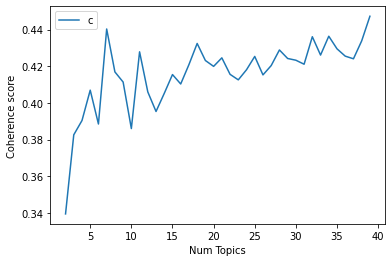

In [122]:
# Show graph
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [123]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.3395
Num Topics = 3  has Coherence Value of 0.3826
Num Topics = 4  has Coherence Value of 0.3904
Num Topics = 5  has Coherence Value of 0.407
Num Topics = 6  has Coherence Value of 0.3885
Num Topics = 7  has Coherence Value of 0.4403
Num Topics = 8  has Coherence Value of 0.4169
Num Topics = 9  has Coherence Value of 0.4114
Num Topics = 10  has Coherence Value of 0.386
Num Topics = 11  has Coherence Value of 0.4279
Num Topics = 12  has Coherence Value of 0.406
Num Topics = 13  has Coherence Value of 0.3954
Num Topics = 14  has Coherence Value of 0.4052
Num Topics = 15  has Coherence Value of 0.4155
Num Topics = 16  has Coherence Value of 0.4103
Num Topics = 17  has Coherence Value of 0.4209
Num Topics = 18  has Coherence Value of 0.4324
Num Topics = 19  has Coherence Value of 0.4231
Num Topics = 20  has Coherence Value of 0.4199
Num Topics = 21  has Coherence Value of 0.4246
Num Topics = 22  has Coherence Value of 0.4156
Num Topics = 23  has Coh

In [124]:
# Select the model and print the topics. 
#Number of Topic is 7 is best.
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.018*"client" + 0.018*"clinician" + 0.015*"work" + 0.015*"online" + '
  '0.013*"participant" + 0.011*"challenge" + 0.011*"pandemic" + '
  '0.010*"session" + 0.009*"report" + 0.008*"therapy"'),
 (1,
  '0.027*"patient" + 0.026*"provider" + 0.025*"veteran" + 0.021*"care" + '
  '0.019*"treatment" + 0.016*"service" + 0.014*"clinical" + 0.012*"provide" + '
  '0.010*"video" + 0.009*"technology"'),
 (2,
  '0.033*"study" + 0.027*"telepsychology" + 0.023*"treatment" + '
  '0.014*"intervention" + 0.013*"family" + 0.012*"include" + '
  '0.011*"participant" + 0.011*"child" + 0.010*"result" + 0.009*"high"'),
 (3,
  '0.035*"psychologist" + 0.035*"practice" + 0.029*"client" + 0.018*"service" '
  '+ 0.016*"technology" + 0.015*"telepsychology" + 0.012*"state" + '
  '0.010*"information" + 0.010*"ethical" + 0.009*"guideline"'),
 (4,
  '0.083*"health" + 0.042*"mental" + 0.037*"care" + 0.012*"individual" + '
  '0.012*"treatment" + 0.012*"service" + 0.012*"support" + 0.011*"community" + '
  '0.010*"

### Finding the dominant topic in each sentence


In [125]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7329,"study, telepsychology, treatment, intervention, family, include, participant, child, result, high",veterans face a variety of stressors related to their military service institute of medicine 201...
1,1,6.0,0.5322,"test, evaluation, assessment, evaluator, child, forensic, administration, remote, interview, con...",the impact of the covid19 pandemic on the child custody evaluation cce community has een astound...
2,2,6.0,0.2895,"test, evaluation, assessment, evaluator, child, forensic, administration, remote, interview, con...",in novemer 2019 covid19—the infectious highly communicale and potentially fatal disease caused y...
3,3,5.0,0.5130,"training, clinic, telepsychology, provide, trainee, supervisor, skill, supervision, clinical, st...",anxiety and depressive disorders are among the most common and impairing mental illnesses in the...
4,4,0.0,0.7242,"client, clinician, work, online, participant, challenge, pandemic, session, report, therapy",in midmarch 2020 the authors—as well as the majority of therapists—were advised to work from hom...
5,5,2.0,0.3757,"study, telepsychology, treatment, intervention, family, include, participant, child, result, high",in early january of 2020 chinese health authorities notified the world health organization who t...
6,6,2.0,0.3388,"study, telepsychology, treatment, intervention, family, include, participant, child, result, high",millions of people with a diagnosale mental disorder within the united states do not have adequa...
7,7,4.0,0.3358,"health, mental, care, individual, treatment, service, support, community, model, access",the primary focus of covid19 has een on its impact on physical health however the pandemic has h...
8,8,6.0,0.5174,"test, evaluation, assessment, evaluator, child, forensic, administration, remote, interview, con...",there is a worldwide gap etween the mental health needs of children and adolescents and them rec...
9,9,0.0,0.4207,"client, clinician, work, online, participant, challenge, pandemic, session, report, therapy",at the time of writing this introduction covid19 has infected millions and killed hundreds of th...


### Find the most representative document for each topic

In [126]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7242,"client, clinician, work, online, participant, challenge, pandemic, session, report, therapy",in midmarch 2020 the authors—as well as the majority of therapists—were advised to work from hom...
1,1.0,0.5697,"patient, provider, veteran, care, treatment, service, clinical, provide, video, technology",meeting the mental health needs of our current veteran population is one of the primary challeng...
2,2.0,0.7383,"study, telepsychology, treatment, intervention, family, include, participant, child, result, high",the use of information and communication technologies has emerged as the next ig frontier in the...
3,3.0,0.7389,"psychologist, practice, client, service, technology, telepsychology, state, information, ethical...",the aility to search the we develop ideas and communicate securely may e the only way in which m...
4,4.0,0.6903,"health, mental, care, individual, treatment, service, support, community, model, access",health disparities across the nation are on the rise most notaly among latinx and hispanic immig...


### Topic distribution across documents

In [127]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"study, telepsychology, treatment, intervention, family, include, participant, child, result, high",8.0,0.1818
1.0,6.0,"test, evaluation, assessment, evaluator, child, forensic, administration, remote, interview, con...",5.0,0.1136
2.0,6.0,"test, evaluation, assessment, evaluator, child, forensic, administration, remote, interview, con...",9.0,0.2045
3.0,5.0,"training, clinic, telepsychology, provide, trainee, supervisor, skill, supervision, clinical, st...",7.0,0.1591
4.0,0.0,"client, clinician, work, online, participant, challenge, pandemic, session, report, therapy",6.0,0.1364
5.0,2.0,"study, telepsychology, treatment, intervention, family, include, participant, child, result, high",5.0,0.1136
6.0,2.0,"study, telepsychology, treatment, intervention, family, include, participant, child, result, high",4.0,0.0909
7.0,4.0,"health, mental, care, individual, treatment, service, support, community, model, access",NaN,NaN
8.0,6.0,"test, evaluation, assessment, evaluator, child, forensic, administration, remote, interview, con...",NaN,NaN
9.0,0.0,"client, clinician, work, online, participant, challenge, pandemic, session, report, therapy",NaN,NaN
